# 프로젝트: CutMix 또는 Mixup 비교실험 하기

CutMix 또는 Mixup을 적용해 모델을 훈련시켜 봅니다.

데이터셋에 두 가지 방법 중 하나를 적용하고, 모델을 학습, 결과를 수치화하고 비교.

In [1]:
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Dataset
import tensorflow_datasets as tfds

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__) # 2.6.0
print(np.__version__) # 1.21.4

2.10.1
1.23.5


# 1. Augmentation을 적용한 데이터셋 만들기

이전 스텝과 아래 코드를 참고하여 데이터셋에 CutMix 또는 Mixup augmentation을 적용

In [ ]:
# config
num_classes = 101 # 120
img_size = 128 # 224
batch_size = 64 # 16

In [3]:
# 기본 전처리
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [img_size, img_size])
    return tf.cast(image, tf.float32) / 255., label

# 기본 Augmentation
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

# One-Hot Encoding
def onehot(image, label):
    label = tf.cast(label, tf.int32)
    label = tf.one_hot(label, num_classes)
    return image, label

# CutMix
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+height//2)
    
    return x_min, y_min, x_max, y_max

def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max): 
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

def cutmix(image, label, prob=1.0): 
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels


# Mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

def mixup(image, label, prob=1.0): 
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

# 데이터 전처리 및 증강 적용 함수
def apply_normalize_on_dataset(ds, is_test=False, with_aug=False,
                               with_cutmix=False, with_mixup=False):

    ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
    if not is_test and with_aug:
        ds = ds.map(augment)
    
    ds = ds.batch(batch_size, drop_remainder=True) # 배치 구성 후 남은 샘플 버림
    
    if not is_test and with_cutmix:
        ds = ds.map(cutmix, num_parallel_calls=2)
        
    elif not is_test and with_mixup:
        ds = ds.map(mixup, num_parallel_calls=2)
    
    else:
        ds = ds.map(onehot, num_parallel_calls=2)
        
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

In [ ]:
# # 기본 전처리
# def normalize_and_resize_img(image, label):
#     # Normalizes images: `uint8` -> `float32`
#     image = tf.image.resize(image, [224, 224])
#     return tf.cast(image, tf.float32) / 255., label

# # 기본 Augmentation
# def augment(image, label):
#     image = tf.image.random_flip_left_right(image)
#     image = tf.image.random_brightness(image, max_delta=0.2)
#     image = tf.clip_by_value(image, 0, 1)
#     return image, label

# # One-Hot Encoding
# def onehot(image, label):
#     label = tf.cast(label, tf.int32)
#     label = tf.one_hot(label, num_classes)
#     return image, label

# # CutMix
# def get_clip_box(image_a, image_b):
#     # image.shape = (height, width, channel)
#     image_size_x = image_a.shape[1]
#     image_size_y = image_a.shape[0]
    
#     # get center of box
#     x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
#     y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

#     # get width, height of box
#     width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
#     height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
#     # clip box in image and get minmax bbox
#     x_min = tf.math.maximum(0, x-width//2)
#     y_min = tf.math.maximum(0, y-height//2)
#     x_max = tf.math.minimum(image_size_x, x+width//2)
#     y_max = tf.math.minimum(image_size_y, y+height//2)
    
#     return x_min, y_min, x_max, y_max

# def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
#     image_size_x = image_a.shape[1]
#     image_size_y = image_a.shape[0] 
#     middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
#     middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
#     middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
#     middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
#     top = image_a[0:y_min, :, :]
#     bottom = image_a[y_max:image_size_y, :, :]
#     mixed_img = tf.concat([top, middle, bottom],axis=0)
    
#     return mixed_img

# def mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max, num_classes=101): # StanDog 120 / Food 101 /
#     image_size_x = image_a.shape[1]
#     image_size_y = image_a.shape[0] 
#     mixed_area = (x_max-x_min)*(y_max-y_min)
#     total_area = image_size_x*image_size_y
#     ratio = tf.cast(mixed_area/total_area, tf.float32)

#     if len(label_a.shape)==0:
#         label_a = tf.one_hot(label_a, num_classes)
#     if len(label_b.shape)==0:
#         label_b = tf.one_hot(label_b, num_classes)
#     mixed_label = (1-ratio)*label_a + ratio*label_b
#     return mixed_label

# def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=101): # StanDog 120 / Food 101 / 
#     mixed_imgs = []
#     mixed_labels = []

#     for i in range(batch_size):
#         image_a = image[i]
#         label_a = label[i]
#         j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
#         image_b = image[j]
#         label_b = label[j]
#         x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
#         mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
#         mixed_labels.append(mix_2_labels(image_a, label_a, label_b, x_min, y_min, x_max, y_max))

#     mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
#     mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
#     return mixed_imgs, mixed_labels


# # Mixup
# def mixup_2_images(image_a, image_b, label_a, label_b):
#     ratio = tf.random.uniform([], 0, 1)
    
#     if len(label_a.shape)==0:
#         label_a = tf.one_hot(label_a, num_classes)
#     if len(label_b.shape)==0:
#         label_b = tf.one_hot(label_b, num_classes)
#     mixed_image= (1-ratio)*image_a + ratio*image_b
#     mixed_label = (1-ratio)*label_a + ratio*label_b
    
#     return mixed_image, mixed_label

# def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=101): # StanDog 120 / Food 101 
#     mixed_imgs = []
#     mixed_labels = []

#     for i in range(batch_size):
#         image_a = image[i]
#         label_a = label[i]
#         j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
#         image_b = image[j]
#         label_b = label[j]
#         mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
#         mixed_imgs.append(mixed_img)
#         mixed_labels.append(mixed_label)

#     mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
#     mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
#     return mixed_imgs, mixed_labels

# # 데이터 전처리 및 증강 적용 함수
# def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False,
#                                with_cutmix=False, with_mixup=False):

#     ds = ds.map(normalize_and_resize_img, num_parallel_calls=2)
    
#     if not is_test and with_aug:
#         ds = ds.map(augment)
    
#     ds = ds.batch(batch_size, drop_remainder=True) # 배치 구성 후 남은 샘플 버림
    
#     if not is_test and with_cutmix:
#         ds = ds.map(cutmix, num_parallel_calls=2)
        
#     elif not is_test and with_mixup:
#         ds = ds.map(mixup, num_parallel_calls=2)
    
#     else:
#         ds = ds.map(onehot, num_parallel_calls=2)
        
#     if not is_test:
#         ds = ds.repeat()
#         ds = ds.shuffle(200)
#     ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
#     return ds

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
    data_dir='D:/DATA/tdfs/stanford_dogs'
)

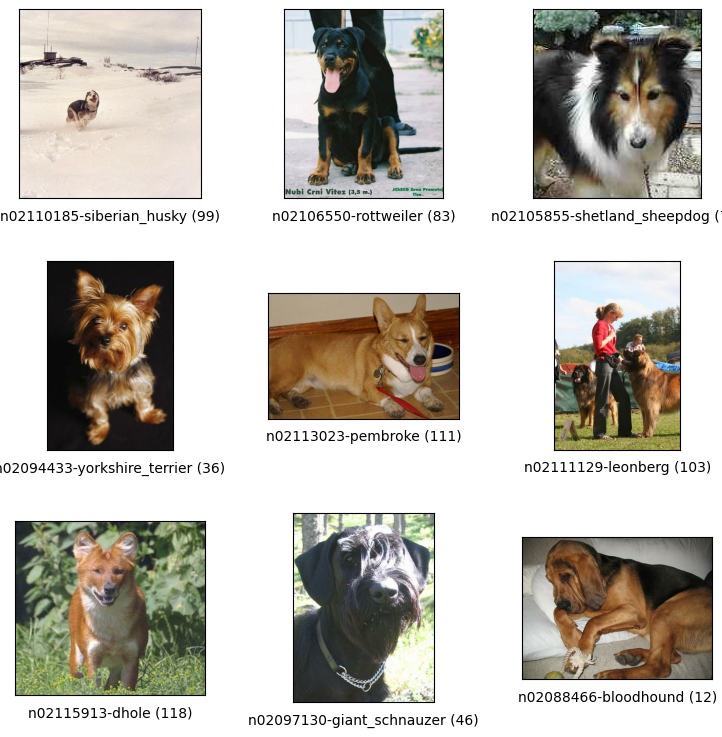

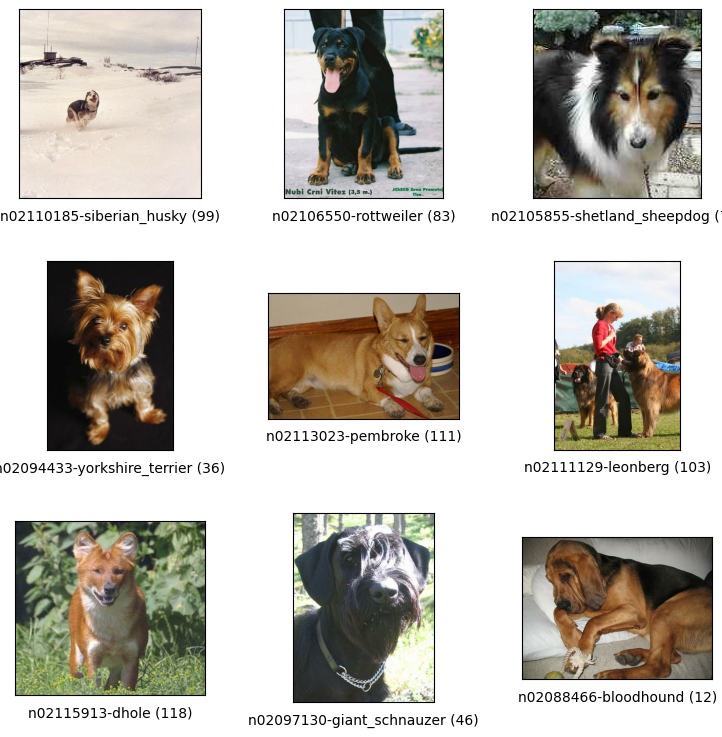

In [4]:
tfds.show_examples(ds_train, ds_info)

In [4]:
num_classes = ds_info.features["label"].num_classes
num_classes

120

In [6]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

# 2. 모델 만들기

앞서 만들었던 것처럼 비교 실험을 위한 모델 두 개 준비.

모델은 ResNet-50을 사용.

In [7]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet',
                                       input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

94765736/94765736 [==============================] - 9s 0us/step


In [10]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet',
                                       input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [11]:
mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet',
                                       input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

In [7]:
cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet',
                                       input_shape=(224,224,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

# 3. 모델 훈련하기

주의!!

위에서 만든 CutMix나 Mixup을 사용하기 위해서는 앞에서 resnet50과 aug_resnet50을 훈련하는 데 사용했던 sparse_categorical_crossentropy() 대신 categorical_crossentropy()를 사용.

In [13]:
EPOCH = 50

In [14]:
resnet50.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics=['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/50
750/750 [==============================] - 56s 71ms/step - loss: 1.0413 - accuracy: 0.7145 - val_loss: 1.2148 - val_accuracy: 0.6445
Epoch 2/50
750/750 [==============================] - 53s 71ms/step - loss: 0.4788 - accuracy: 0.8743 - val_loss: 1.0371 - val_accuracy: 0.6990
Epoch 3/50
750/750 [==============================] - 53s 71ms/step - loss: 0.1646 - accuracy: 0.9702 - val_loss: 0.9406 - val_accuracy: 0.7308
Epoch 4/50
750/750 [==============================] - 53s 71ms/step - loss: 0.0732 - accuracy: 0.9923 - val_loss: 0.9560 - val_accuracy: 0.7322
Epoch 5/50
750/750 [==============================] - 53s 71ms/step - loss: 0.0333 - accuracy: 0.9976 - val_loss: 0.9276 - val_accuracy: 0.7424
Epoch 6/50
750/750 [==============================] - 53s 71ms/step - loss: 0.0230 - accuracy: 0.9982 - val_loss: 0.9538 - val_accuracy: 0.7415
Epoch 7/50
750/750 [==============================] - 53s 71ms/step - loss: 0.0132 - accuracy: 0.9990 - val_loss: 0.9763 - val_accuracy:

In [15]:
aug_resnet50.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     metrics=['accuracy'])

history_resnet50_with_aug = aug_resnet50.fit(
    ds_train_aug, # 기본 augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/50
750/750 [==============================] - 57s 72ms/step - loss: 2.2843 - accuracy: 0.4333 - val_loss: 3.0053 - val_accuracy: 0.2587
Epoch 2/50
750/750 [==============================] - 53s 71ms/step - loss: 0.9994 - accuracy: 0.7134 - val_loss: 1.4873 - val_accuracy: 0.5849
Epoch 3/50
750/750 [==============================] - 53s 71ms/step - loss: 0.5819 - accuracy: 0.8371 - val_loss: 1.0482 - val_accuracy: 0.6965
Epoch 4/50
750/750 [==============================] - 53s 71ms/step - loss: 0.3136 - accuracy: 0.9211 - val_loss: 1.0475 - val_accuracy: 0.7008
Epoch 5/50
750/750 [==============================] - 53s 71ms/step - loss: 0.2040 - accuracy: 0.9521 - val_loss: 1.0791 - val_accuracy: 0.6940
Epoch 6/50
750/750 [==============================] - 53s 71ms/step - loss: 0.1353 - accuracy: 0.9732 - val_loss: 0.9675 - val_accuracy: 0.7312
Epoch 7/50
750/750 [==============================] - 53s 71ms/step - loss: 0.0761 - accuracy: 0.9880 - val_loss: 1.2770 - val_accuracy:

In [16]:
mixup_resnet50.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                       metrics=['accuracy'])

history_resnet50_with_mixup = mixup_resnet50.fit(
    ds_train_aug_mixup, # 기본 augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/50
750/750 [==============================] - 57s 72ms/step - loss: 3.8022 - accuracy: 0.2151 - val_loss: 3.5782 - val_accuracy: 0.1789
Epoch 2/50
750/750 [==============================] - 54s 72ms/step - loss: 2.9644 - accuracy: 0.4428 - val_loss: 1.7751 - val_accuracy: 0.5225
Epoch 3/50
750/750 [==============================] - 54s 72ms/step - loss: 2.7116 - accuracy: 0.5290 - val_loss: 1.4362 - val_accuracy: 0.5951
Epoch 4/50
750/750 [==============================] - 54s 72ms/step - loss: 2.5250 - accuracy: 0.5972 - val_loss: 1.2882 - val_accuracy: 0.6377
Epoch 5/50
750/750 [==============================] - 54s 72ms/step - loss: 2.4274 - accuracy: 0.6328 - val_loss: 1.5202 - val_accuracy: 0.5870
Epoch 6/50
750/750 [==============================] - 54s 72ms/step - loss: 2.3318 - accuracy: 0.6714 - val_loss: 1.3697 - val_accuracy: 0.6217
Epoch 7/50
750/750 [==============================] - 54s 72ms/step - loss: 2.2536 - accuracy: 0.6970 - val_loss: 1.2736 - val_accuracy:

In [23]:
cutmix_resnet50.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics=['accuracy'])

history_resnet50_with_cutmix = cutmix_resnet50.fit(
    ds_train_aug_cutmix, # 기본 augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/50
750/750 [==============================] - 59s 74ms/step - loss: 3.9110 - accuracy: 0.1967 - val_loss: 3.1569 - val_accuracy: 0.2455
Epoch 2/50
750/750 [==============================] - 55s 73ms/step - loss: 3.0597 - accuracy: 0.3941 - val_loss: 1.6603 - val_accuracy: 0.5522
Epoch 3/50
750/750 [==============================] - 55s 73ms/step - loss: 2.7779 - accuracy: 0.4823 - val_loss: 1.6286 - val_accuracy: 0.5517
Epoch 4/50
750/750 [==============================] - 55s 73ms/step - loss: 2.5962 - accuracy: 0.5357 - val_loss: 1.0964 - val_accuracy: 0.6842
Epoch 5/50
750/750 [==============================] - 56s 74ms/step - loss: 2.4414 - accuracy: 0.5894 - val_loss: 1.1531 - val_accuracy: 0.6740
Epoch 6/50
750/750 [==============================] - 56s 74ms/step - loss: 2.3521 - accuracy: 0.6157 - val_loss: 1.1230 - val_accuracy: 0.6817
Epoch 7/50
750/750 [==============================] - 56s 74ms/step - loss: 2.2665 - accuracy: 0.6434 - val_loss: 1.1777 - val_accuracy:

# 4. 훈련 과정 시각화하기

훈련 과정의 히스토리를 그래프로 시각화

In [4]:
def visualize_training(history_resnet50_no_aug, history_resnet50_with_aug, history_resnet50_with_mixup, history_resnet50_with_cutmix, acc_ylim=(0.62, 0.76), loss_ylim=(0.75, 1.75), validation=True):
    plt.figure(figsize=(16, 11))
    plt.subplot(221)
    plt.plot(history_resnet50_no_aug.history['val_accuracy' if validation else 'accuracy'], 'gray')
    plt.plot(history_resnet50_with_aug.history['val_accuracy' if validation else 'accuracy'], 'b')
    plt.plot(history_resnet50_with_mixup.history['val_accuracy' if validation else 'accuracy'], 'g')
    plt.plot(history_resnet50_with_cutmix.history['val_accuracy' if validation else 'accuracy'], 'r')
    plt.title(f'Model {"validation" if validation else "training"} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['No Augmentation', 'With Augmentation', 'Aug with Mixup', 'Aug with CutMix'], loc='lower right')
    # plt.show()

    plt.subplot(222)
    plt.plot(history_resnet50_no_aug.history['val_accuracy' if validation else 'accuracy'], 'gray')
    plt.plot(history_resnet50_with_aug.history['val_accuracy' if validation else 'accuracy'], 'b')
    plt.plot(history_resnet50_with_mixup.history['val_accuracy' if validation else 'accuracy'], 'g')
    plt.plot(history_resnet50_with_cutmix.history['val_accuracy' if validation else 'accuracy'], 'r')
    plt.title(f'Model {"validation" if validation else "training"} accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.grid(True)
    plt.ylim(acc_ylim)

    plt.subplot(223)
    plt.plot(history_resnet50_no_aug.history['val_loss' if validation else 'loss'], 'gray')
    plt.plot(history_resnet50_with_aug.history['val_loss' if validation else 'loss'], 'b')
    plt.plot(history_resnet50_with_mixup.history['val_loss' if validation else 'loss'], 'g')
    plt.plot(history_resnet50_with_cutmix.history['val_loss' if validation else 'loss'], 'r')
    plt.title(f'Model {"validation" if validation else "training"} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['No Augmentation', 'With Augmentation', 'Aug with Mixup', 'Aug with CutMix'], loc='upper right')

    plt.subplot(224)
    plt.plot(history_resnet50_no_aug.history['val_loss' if validation else 'loss'], 'gray')
    plt.plot(history_resnet50_with_aug.history['val_loss' if validation else 'loss'], 'b')
    plt.plot(history_resnet50_with_mixup.history['val_loss' if validation else 'loss'], 'g')
    plt.plot(history_resnet50_with_cutmix.history['val_loss' if validation else 'loss'], 'r')
    plt.title(f'Model {"validation" if validation else "training"} loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.grid(True) 
    plt.ylim(loss_ylim)

    plt.show()

- 훈련 과정에서 Validation Set에 대한 정확도 및 손실 변화

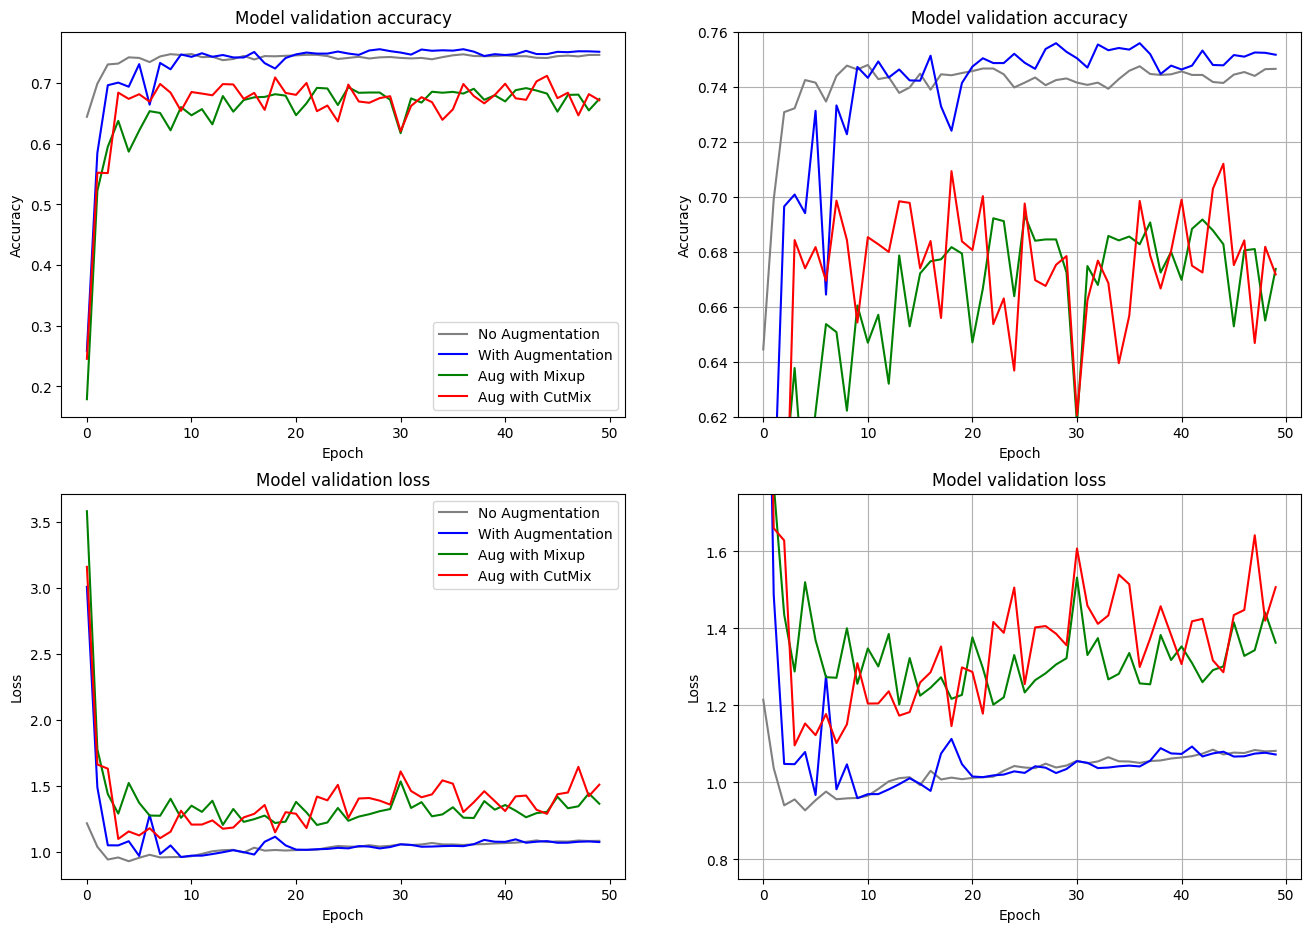

In [69]:
visualize_training(history_resnet50_no_aug, history_resnet50_with_aug, history_resnet50_with_mixup, history_resnet50_with_cutmix)

- 최종 정확도 데이터 프레임에 저장

In [90]:
val_df = pd.DataFrame({"Method" : ["No Aug", "Basic Aug", "Basic + Mixup" , "Basic + Cutmix"],
                       "Val Acc": [round(history_resnet50_no_aug.history['val_accuracy'][-1], 4)*100,
                                  round(history_resnet50_with_aug.history['val_accuracy'][-1], 4)*100,
                                  round(history_resnet50_with_mixup.history['val_accuracy'][-1], 4)*100,
                                  round(history_resnet50_with_cutmix.history['val_accuracy'][-1], 4)*100]})

val_df["differency"] = val_df["Val Acc"] - val_df["Val Acc"][0]

- 훈련 과정에서 Train Set에 대한 정확도 및 손실 변화

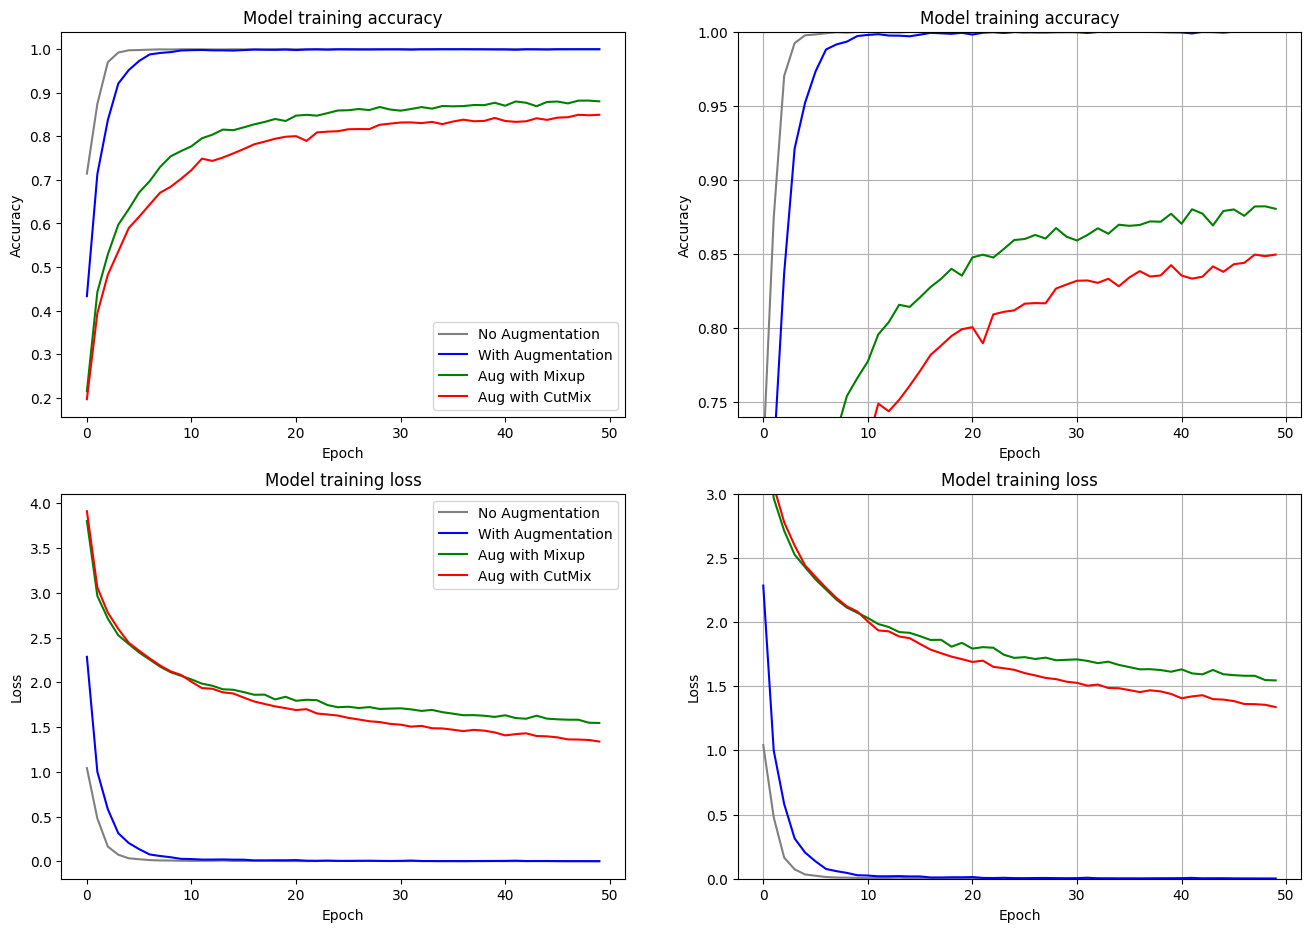

In [68]:
visualize_training(history_resnet50_no_aug, history_resnet50_with_aug, history_resnet50_with_mixup, history_resnet50_with_cutmix, validation=False, acc_ylim=(0.74, 1.0), loss_ylim=(0.0, 3.0))

# 5. Augmentation에 의한 모델 성능 비교

No Augmentation, 기본 Augmentation, 기본 + CutMix 적용, 기본 + Mixup 적용 이상 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교해 보고, Augmentation 방법들의 영향도에 대해 분석.

In [91]:
val_df

Method  Val Acc  differency
0          No Aug    74.65        0.00
1       Basic Aug    75.16        0.51
2   Basic + Mixup    67.37       -7.28
3  Basic + Cutmix    67.18       -7.47

- 각 방식의 Augmentation을 하지 않은 것 대비 정확도 변화는 위 표에서 확인 가능.

**예상과 다르다**
- 단순하게 일반화 성능을 높여준다는 증강 방식을 적용하여 정확도가 높아질 것이라 예상.
    - 그러나 Validation Set 기준 정확도는 Augmentation을 적용하지 않거나 단순 Flip등의 Augmentation을 적용한 모델보다 CutMix, MixUp을 적용한 모델이 더 낮은 정확도를 보임.

- Mixup, CutMix 방식의 데이터 증강은 정규화 효과와 유사하기 때문에 학습은 느리지만 점차 보다 나은 정확도를 가져갈 것이라 예상.
    - 그래서 그 효과를 확인하기 위해 20 에포크를 돌려봤을 때는 충분하지 않아 보여서 50 에포크까지 돌려보았으나 더 이상 validation 정확도가 개선되지 않는 모습을 확인.

**무엇이 잘못됐을까**
- 해당 데이터셋은 견종 간의 미묘한 특징적 차이를 분류하는 문제이다. 그러나 CutMix, Mixup의 방식으로 잘라내고 섞는 과정에서 정규화 효과를 넘어서 미묘하지만 중요한 특성을 가려서 학습을 방해하기만 하는 효과를 보인 것은 아닌지 의심된다.

---

# 6. 추가 실험 (데이터셋 변경)

In [5]:
(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    as_supervised=True,
    shuffle_files=False,
    with_info=True,
)

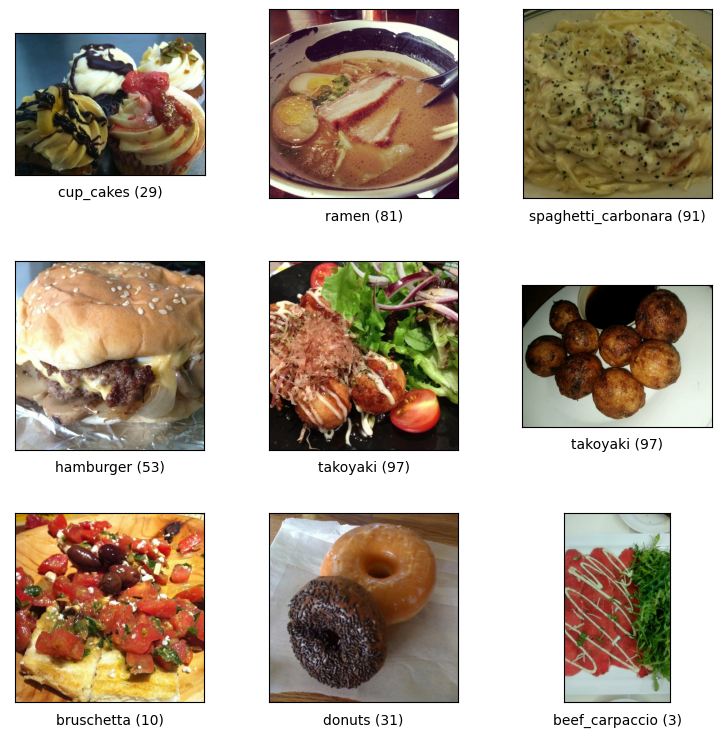

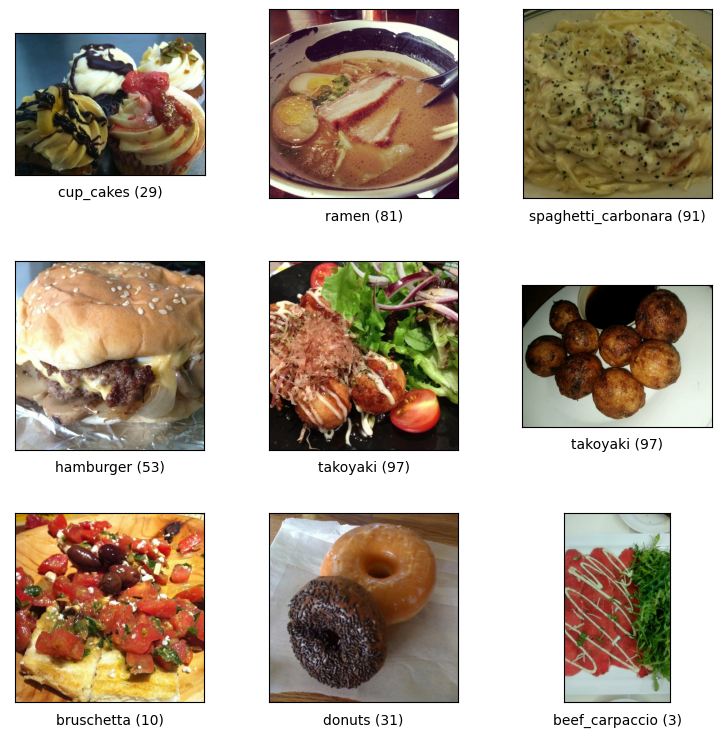

In [17]:
tfds.show_examples(ds_test, ds_info)

In [6]:
num_classes = ds_info.features["label"].num_classes
num_classes

101

In [7]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_aug_mixup = apply_normalize_on_dataset(ds_train, with_aug=True, with_mixup=True)
ds_train_aug_cutmix = apply_normalize_on_dataset(ds_train, with_aug=True, with_cutmix=True)

In [8]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet',
                                       input_shape=(img_size,img_size,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet',
                                       input_shape=(img_size,img_size,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

mixup_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet',
                                       input_shape=(img_size,img_size,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])

cutmix_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(include_top=False, weights='imagenet',
                                       input_shape=(img_size,img_size,3), pooling='avg'),
    keras.layers.Dense(num_classes, activation='softmax')])


In [13]:
EPOCH = 10

In [ ]:
# 128*128 / batch 64 / 16min
resnet50.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics=['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['validation'].num_examples/batch_size),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/10
1183/1183 [==============================] - 100s 81ms/step - loss: 2.5951 - accuracy: 0.3859 - val_loss: 1.7085 - val_accuracy: 0.5592
Epoch 2/10
1183/1183 [==============================] - 97s 82ms/step - loss: 1.3376 - accuracy: 0.6557 - val_loss: 1.5303 - val_accuracy: 0.6024
Epoch 3/10
1183/1183 [==============================] - 96s 81ms/step - loss: 0.7141 - accuracy: 0.8225 - val_loss: 1.4279 - val_accuracy: 0.6290
Epoch 4/10
1183/1183 [==============================] - 96s 81ms/step - loss: 0.2956 - accuracy: 0.9413 - val_loss: 1.4404 - val_accuracy: 0.6410
Epoch 5/10
1183/1183 [==============================] - 96s 81ms/step - loss: 0.0974 - accuracy: 0.9875 - val_loss: 1.4833 - val_accuracy: 0.6416
Epoch 6/10
1183/1183 [==============================] - 96s 81ms/step - loss: 0.0346 - accuracy: 0.9979 - val_loss: 1.5298 - val_accuracy: 0.6426
Epoch 7/10
1183/1183 [==============================] - 96s 81ms/step - loss: 0.0175 - accuracy: 0.9997 - val_loss: 1.5681 

In [ ]:
# batch 64 / 128*128 / 16m
aug_resnet50.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     metrics=['accuracy'])

history_resnet50_with_aug = aug_resnet50.fit(
    ds_train_aug, # 기본 augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['validation'].num_examples/batch_size),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/10
1183/1183 [==============================] - 99s 81ms/step - loss: 2.6764 - accuracy: 0.3684 - val_loss: 1.8540 - val_accuracy: 0.5233
Epoch 2/10
1183/1183 [==============================] - 96s 81ms/step - loss: 1.5748 - accuracy: 0.5940 - val_loss: 1.5637 - val_accuracy: 0.5926
Epoch 3/10
1183/1183 [==============================] - 96s 81ms/step - loss: 1.1468 - accuracy: 0.6989 - val_loss: 1.3998 - val_accuracy: 0.6275
Epoch 4/10
1183/1183 [==============================] - 96s 81ms/step - loss: 0.8330 - accuracy: 0.7820 - val_loss: 1.3570 - val_accuracy: 0.6475
Epoch 5/10
1183/1183 [==============================] - 96s 81ms/step - loss: 0.5906 - accuracy: 0.8498 - val_loss: 1.3989 - val_accuracy: 0.6451
Epoch 6/10
1183/1183 [==============================] - 96s 81ms/step - loss: 0.4086 - accuracy: 0.8995 - val_loss: 1.3562 - val_accuracy: 0.6593
Epoch 7/10
1183/1183 [==============================] - 96s 81ms/step - loss: 0.2749 - accuracy: 0.9370 - val_loss: 1.4049 -

In [15]:
mixup_resnet50.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                       metrics=['accuracy'])

history_resnet50_with_mixup = mixup_resnet50.fit(
    ds_train_aug_mixup, # 기본 augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['validation'].num_examples/batch_size),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/10
1183/1183 [==============================] - 103s 84ms/step - loss: 3.8983 - accuracy: 0.1906 - val_loss: 2.3163 - val_accuracy: 0.4229
Epoch 2/10
1183/1183 [==============================] - 99s 83ms/step - loss: 3.2410 - accuracy: 0.3589 - val_loss: 1.8522 - val_accuracy: 0.5332
Epoch 3/10
1183/1183 [==============================] - 99s 83ms/step - loss: 3.0123 - accuracy: 0.4267 - val_loss: 1.6922 - val_accuracy: 0.5718
Epoch 4/10
1183/1183 [==============================] - 99s 84ms/step - loss: 2.8916 - accuracy: 0.4636 - val_loss: 1.5560 - val_accuracy: 0.6104
Epoch 5/10
1183/1183 [==============================] - 99s 83ms/step - loss: 2.7870 - accuracy: 0.4984 - val_loss: 1.4932 - val_accuracy: 0.6176
Epoch 6/10
1183/1183 [==============================] - 99s 83ms/step - loss: 2.6996 - accuracy: 0.5256 - val_loss: 1.7674 - val_accuracy: 0.5579
Epoch 7/10
1183/1183 [==============================] - 98s 83ms/step - loss: 2.6397 - accuracy: 0.5468 - val_loss: 1.5089 

In [21]:
# Batch 64 / 128*128 / 5min
cutmix_resnet50.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics=['accuracy'])

history_resnet50_with_cutmix = cutmix_resnet50.fit(
    ds_train_aug_cutmix, # 기본 augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['validation'].num_examples/batch_size),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/10
1183/1183 [==============================] - 103s 83ms/step - loss: 3.9775 - accuracy: 0.1699 - val_loss: 2.3843 - val_accuracy: 0.4215
Epoch 2/10
1183/1183 [==============================] - 98s 83ms/step - loss: 3.3039 - accuracy: 0.3271 - val_loss: 1.8819 - val_accuracy: 0.5347
Epoch 3/10
1183/1183 [==============================] - 98s 83ms/step - loss: 3.0721 - accuracy: 0.3889 - val_loss: 1.7547 - val_accuracy: 0.5617
Epoch 4/10
1183/1183 [==============================] - 98s 83ms/step - loss: 2.9111 - accuracy: 0.4291 - val_loss: 1.5407 - val_accuracy: 0.6150
Epoch 5/10
1183/1183 [==============================] - 98s 83ms/step - loss: 2.8109 - accuracy: 0.4583 - val_loss: 1.4683 - val_accuracy: 0.6311
Epoch 6/10
1183/1183 [==============================] - 98s 83ms/step - loss: 2.7150 - accuracy: 0.4832 - val_loss: 1.3773 - val_accuracy: 0.6520
Epoch 7/10
1183/1183 [==============================] - 98s 83ms/step - loss: 2.6441 - accuracy: 0.5041 - val_loss: 1.3592 

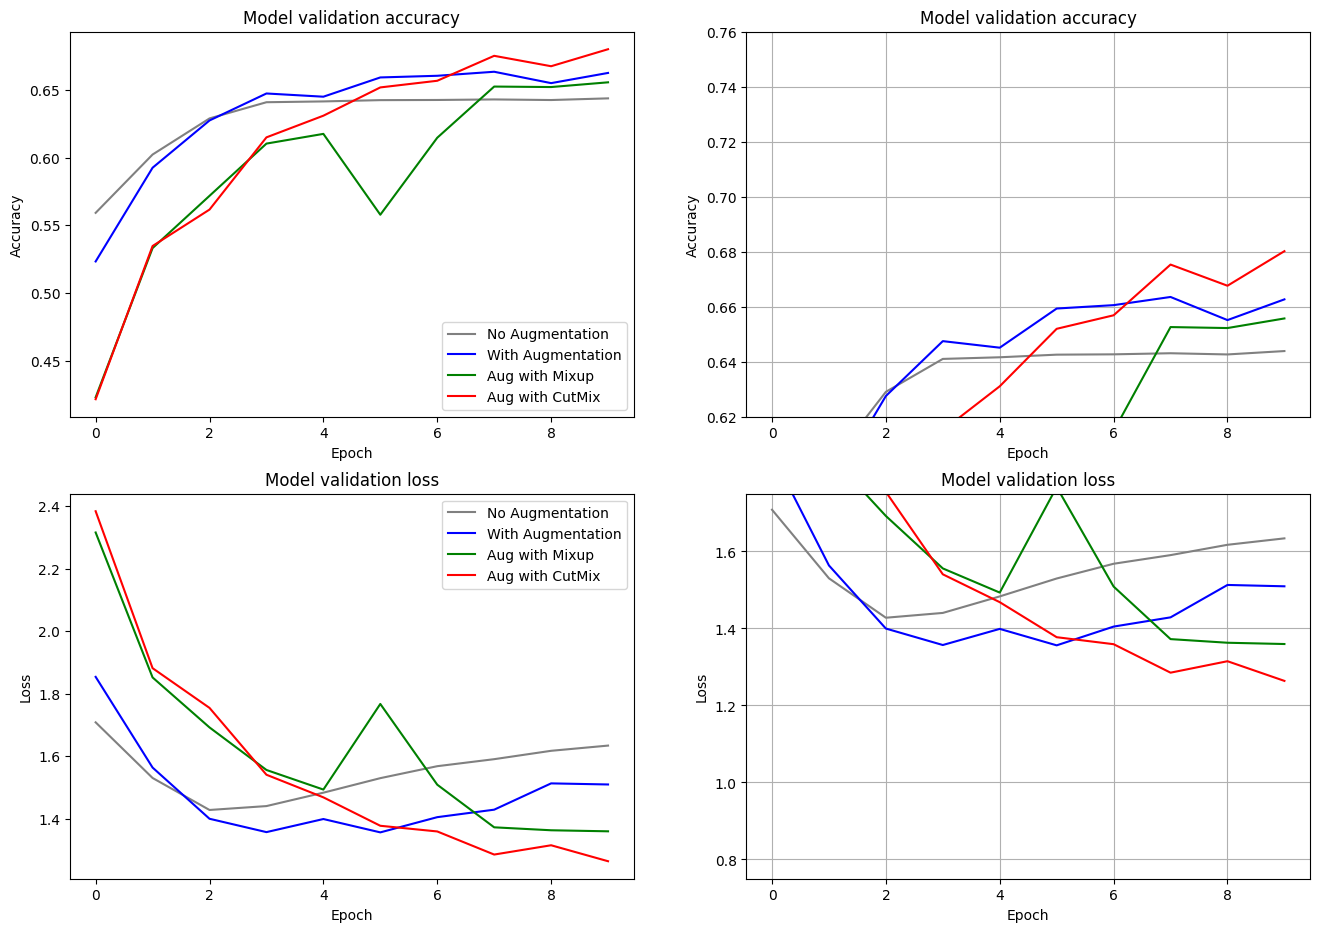

In [22]:
visualize_training(history_resnet50_no_aug, history_resnet50_with_aug, history_resnet50_with_mixup, history_resnet50_with_cutmix)

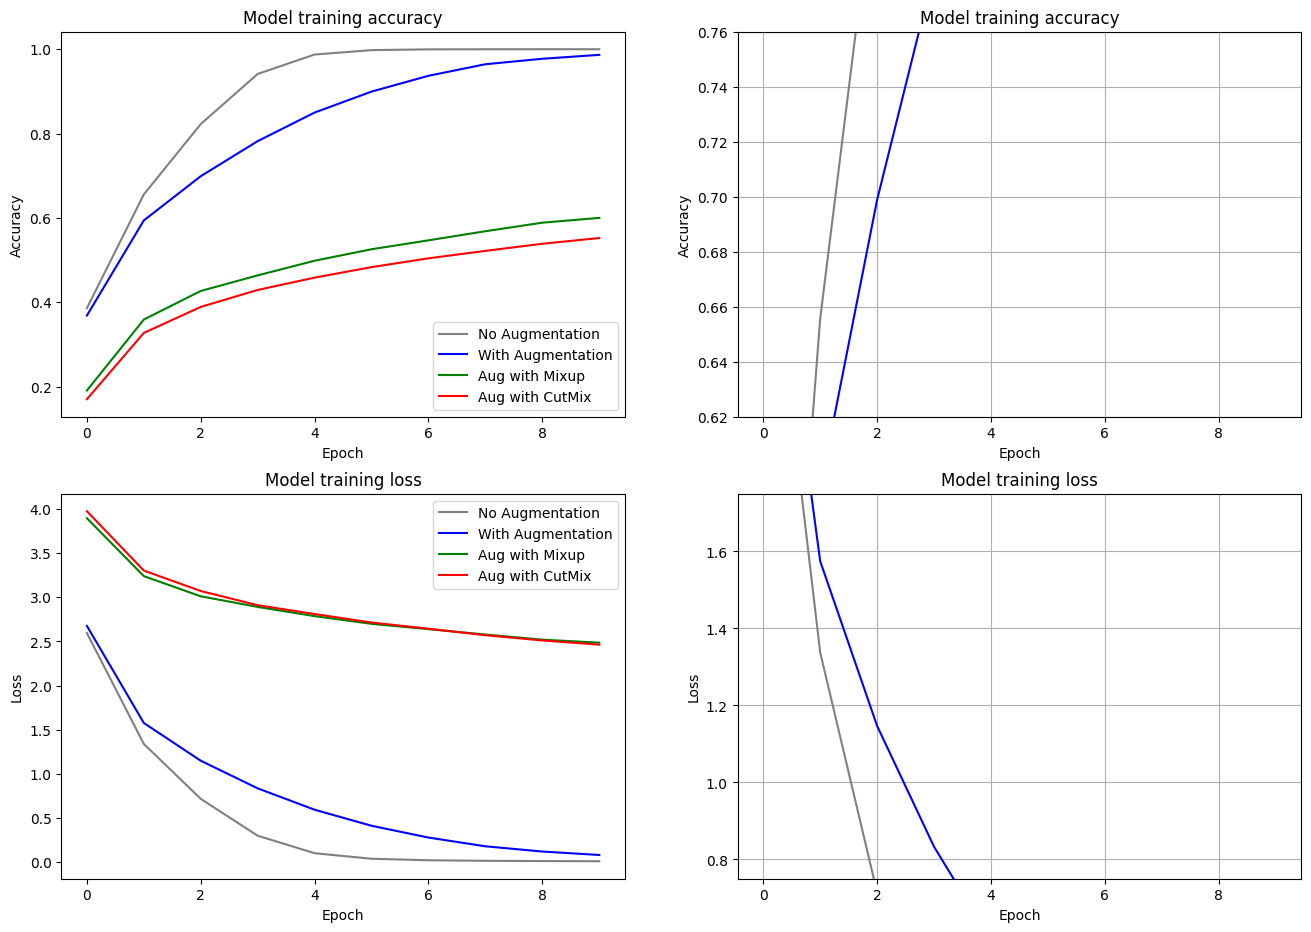

In [24]:
visualize_training(history_resnet50_no_aug, history_resnet50_with_aug, history_resnet50_with_mixup, history_resnet50_with_cutmix, validation=False)

In [25]:
EPOCH = 15

In [26]:
# additional 5 epoch
history_resnet50_no_aug2 = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['validation'].num_examples/batch_size),
    epochs=EPOCH, initial_epoch=10, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 11/15
1183/1183 [==============================] - 97s 81ms/step - loss: 0.0053 - accuracy: 1.0000 - val_loss: 1.6558 - val_accuracy: 0.6435
Epoch 12/15
1183/1183 [==============================] - 97s 82ms/step - loss: 0.0045 - accuracy: 1.0000 - val_loss: 1.6701 - val_accuracy: 0.6431
Epoch 13/15
1183/1183 [==============================] - 97s 82ms/step - loss: 0.0040 - accuracy: 1.0000 - val_loss: 1.6845 - val_accuracy: 0.6428
Epoch 14/15
1183/1183 [==============================] - 96s 81ms/step - loss: 0.0035 - accuracy: 1.0000 - val_loss: 1.6977 - val_accuracy: 0.6431
Epoch 15/15
1183/1183 [==============================] - 96s 81ms/step - loss: 0.0031 - accuracy: 1.0000 - val_loss: 1.7056 - val_accuracy: 0.6428


In [27]:
# additional 5 epoch
history_resnet50_with_aug2 = aug_resnet50.fit(
    ds_train_aug, # 기본 augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['validation'].num_examples/batch_size),
    epochs=EPOCH, initial_epoch=10, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 11/15
1183/1183 [==============================] - 99s 82ms/step - loss: 0.0521 - accuracy: 0.9920 - val_loss: 1.5096 - val_accuracy: 0.6660
Epoch 12/15
1183/1183 [==============================] - 97s 82ms/step - loss: 0.0368 - accuracy: 0.9954 - val_loss: 1.5189 - val_accuracy: 0.6729
Epoch 13/15
1183/1183 [==============================] - 97s 82ms/step - loss: 0.0283 - accuracy: 0.9965 - val_loss: 1.5073 - val_accuracy: 0.6752
Epoch 14/15
1183/1183 [==============================] - 98s 83ms/step - loss: 0.0216 - accuracy: 0.9977 - val_loss: 1.5329 - val_accuracy: 0.6778
Epoch 15/15
1183/1183 [==============================] - 98s 82ms/step - loss: 0.0172 - accuracy: 0.9982 - val_loss: 1.5508 - val_accuracy: 0.6755


In [28]:
# additional 5 epoch
history_resnet50_with_mixup2 = mixup_resnet50.fit(
    ds_train_aug_mixup, # 기본 augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['validation'].num_examples/batch_size),
    epochs=EPOCH, initial_epoch=10, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 11/15
1183/1183 [==============================] - 101s 83ms/step - loss: 2.4389 - accuracy: 0.6185 - val_loss: 1.3193 - val_accuracy: 0.6634
Epoch 12/15
1183/1183 [==============================] - 97s 82ms/step - loss: 2.3924 - accuracy: 0.6297 - val_loss: 1.3799 - val_accuracy: 0.6497
Epoch 13/15
1183/1183 [==============================] - 97s 82ms/step - loss: 2.3585 - accuracy: 0.6419 - val_loss: 1.3300 - val_accuracy: 0.6630
Epoch 14/15
1183/1183 [==============================] - 97s 82ms/step - loss: 2.3317 - accuracy: 0.6545 - val_loss: 1.3473 - val_accuracy: 0.6598
Epoch 15/15
1183/1183 [==============================] - 97s 82ms/step - loss: 2.2901 - accuracy: 0.6715 - val_loss: 1.3046 - val_accuracy: 0.6728


In [29]:
# additional 5 epoch
history_resnet50_with_cutmix2 = cutmix_resnet50.fit(
    ds_train_aug_cutmix, # 기본 augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/batch_size),
    validation_steps=int(ds_info.splits['validation'].num_examples/batch_size),
    epochs=EPOCH, initial_epoch=10, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 11/15
1183/1183 [==============================] - 101s 83ms/step - loss: 2.4186 - accuracy: 0.5618 - val_loss: 1.1890 - val_accuracy: 0.6990
Epoch 12/15
1183/1183 [==============================] - 99s 84ms/step - loss: 2.3708 - accuracy: 0.5783 - val_loss: 1.2519 - val_accuracy: 0.6829
Epoch 13/15
1183/1183 [==============================] - 100s 84ms/step - loss: 2.3296 - accuracy: 0.5914 - val_loss: 1.2522 - val_accuracy: 0.6850
Epoch 14/15
1183/1183 [==============================] - 98s 83ms/step - loss: 2.2933 - accuracy: 0.5991 - val_loss: 1.2031 - val_accuracy: 0.7003
Epoch 15/15
1183/1183 [==============================] - 99s 83ms/step - loss: 2.2510 - accuracy: 0.6101 - val_loss: 1.1598 - val_accuracy: 0.7079


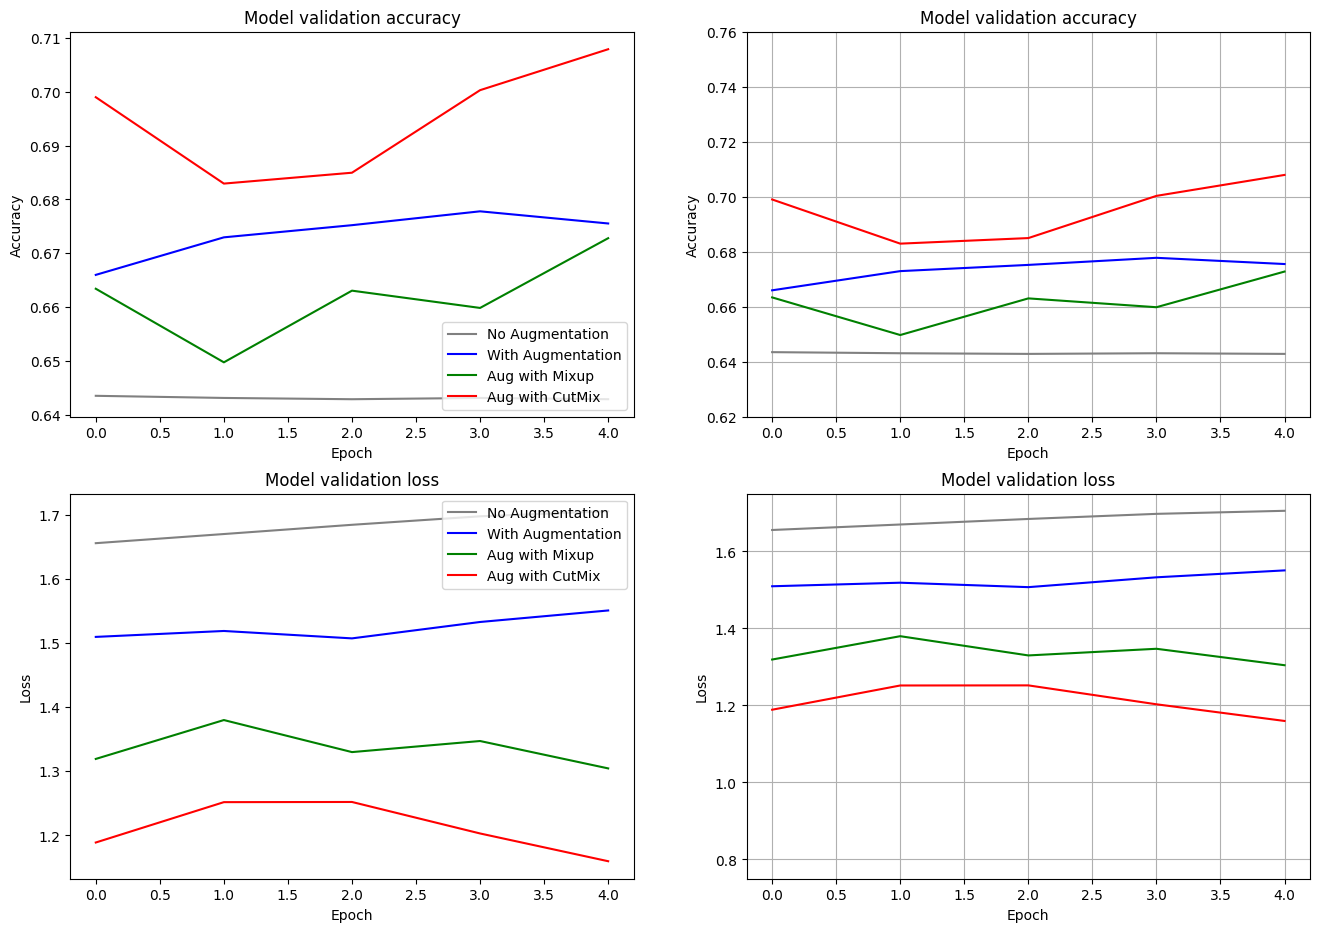

In [37]:
visualize_training(history_resnet50_no_aug2, history_resnet50_with_aug2, history_resnet50_with_mixup2, history_resnet50_with_cutmix2)

In [30]:
def merge_history(history1, history2):
    all_history = {}
    for key in history1.history:
        all_history[key] = history1.history[key] + history2.history[key]

    return all_history

In [31]:
history_no_aug = merge_history(history_resnet50_no_aug, history_resnet50_no_aug2)
history_with_aug = merge_history(history_resnet50_with_aug,history_resnet50_with_aug2)
history_with_mixup = merge_history(history_resnet50_with_mixup,history_resnet50_with_mixup2)
history_with_cutmix = merge_history(history_resnet50_with_cutmix, history_resnet50_with_cutmix2)

In [51]:
def visualize_result(train_res=True, val_res=True, loss_convert=False):
    histories = [history_no_aug, history_with_aug, history_with_mixup, history_with_cutmix]
    model_names = ['No Aug', 'Basic Aug', 'Mixup', 'CutMix']
    num_epochs = range(1, len(history_no_aug['accuracy']) + 1) # 에포크 수
    colors = plt.cm.get_cmap('tab10', len(histories)) # 모델별 색상 지정

    plt.figure(figsize=(12, 8))

    for i, history in enumerate(histories):
        train_acc = history.get('loss' if loss_convert else 'accuracy')
        val_acc = history.get('val_loss' if loss_convert else 'val_accuracy')
        color = colors(i)

        if train_acc and val_acc:
            if train_res:
                plt.plot(num_epochs, train_acc, label=f'{model_names[i]} Train {"Loss" if loss_convert else "Accuracy"}', linestyle='--', color=color)
            if val_res:
                plt.plot(num_epochs, val_acc, label=f'{model_names[i]} Validation {"Loss" if loss_convert else "Accuracy"}', linestyle='-', color=color)

    plt.title(f'Training and Validation {"Loss" if loss_convert else "Accuracy"} of Multiple Models')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

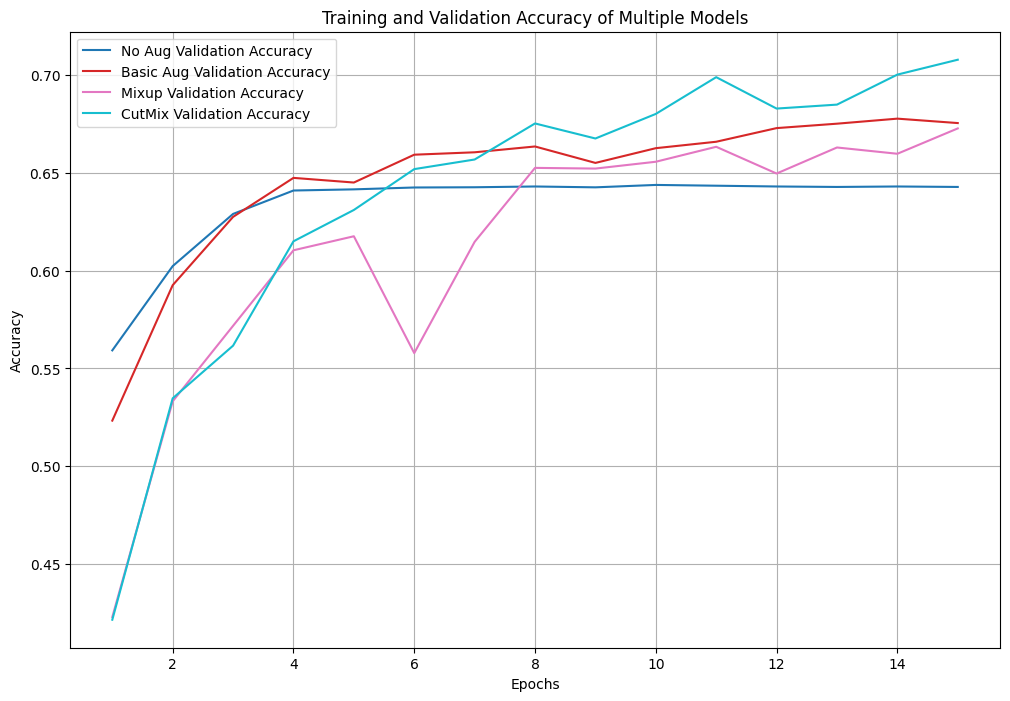

In [53]:
visualize_result(train_res=False, val_res=True)

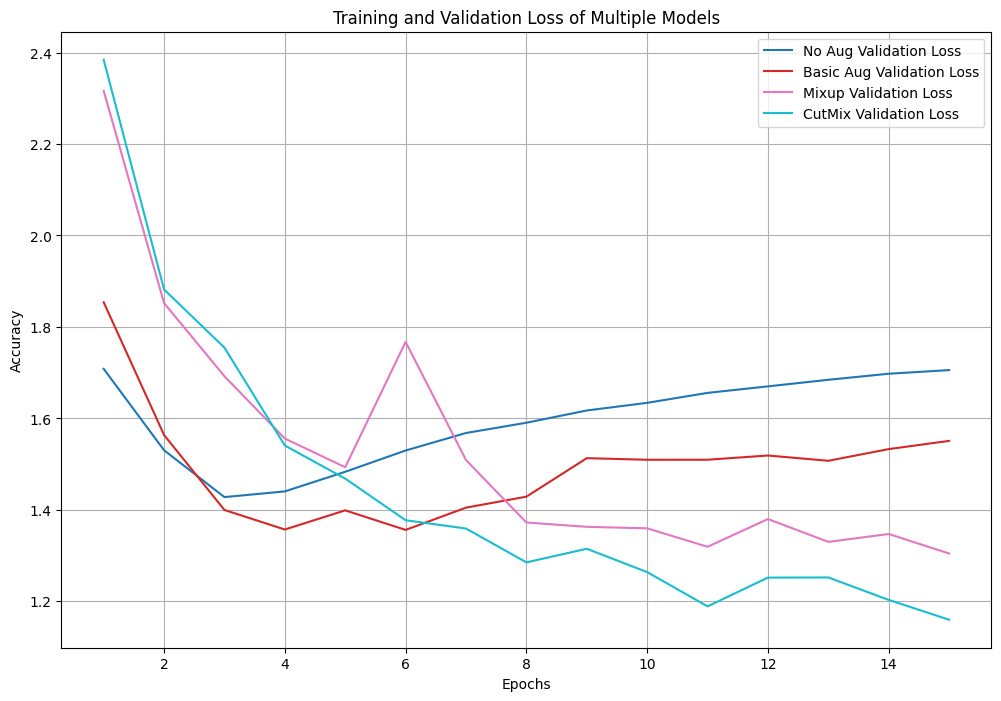

In [54]:
visualize_result(train_res=False, val_res=True, loss_convert=True)

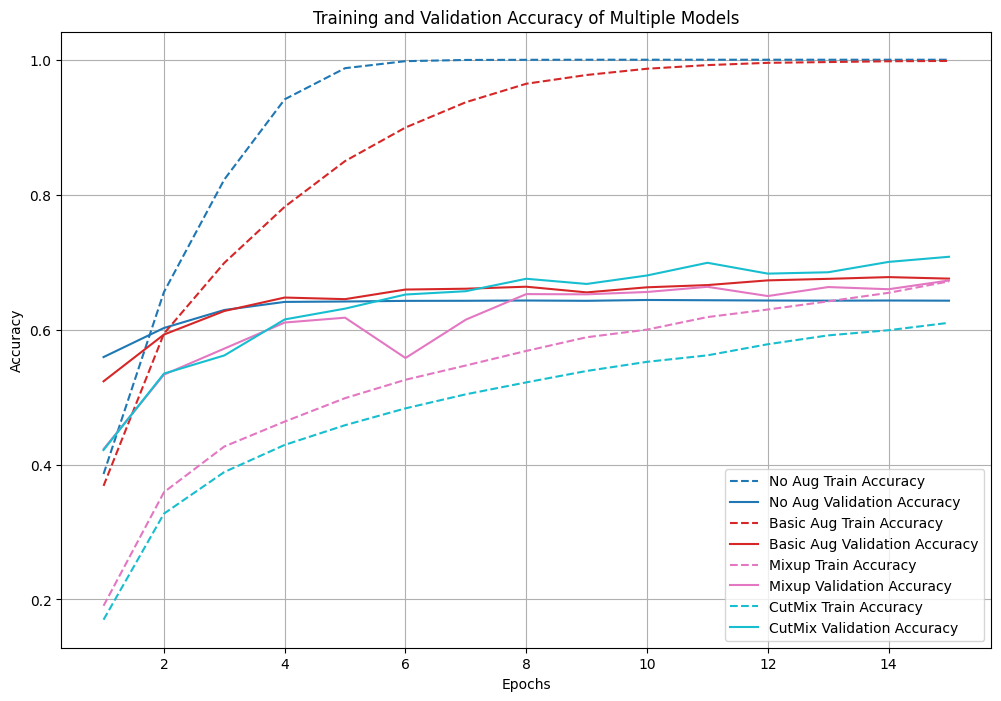

In [55]:
visualize_result(train_res=True, val_res=True)

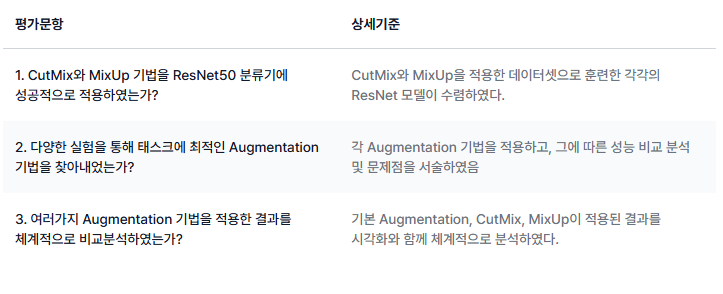

---

In [60]:
aug_resnet50.compile(loss='categorical_crossentropy',
                     optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                     metrics=['accuracy'])

history_resnet50_with_aug = aug_resnet50.fit(
    ds_train_aug, # 기본 augmentation 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['validation'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/5


4734/4734 [==============================] - 173s 36ms/step - loss: 2.4433 - accuracy: 0.4078 - val_loss: 2.3572 - val_accuracy: 0.4270
Epoch 2/5
4734/4734 [==============================] - 170s 36ms/step - loss: 1.5176 - accuracy: 0.6050 - val_loss: 1.8003 - val_accuracy: 0.5455
Epoch 3/5
4734/4734 [==============================] - 171s 36ms/step - loss: 1.1129 - accuracy: 0.7026 - val_loss: 1.4070 - val_accuracy: 0.6454
Epoch 4/5
4734/4734 [==============================] - 171s 36ms/step - loss: 0.8199 - accuracy: 0.7749 - val_loss: 1.6797 - val_accuracy: 0.6039
Epoch 5/5
4734/4734 [==============================] - 169s 36ms/step - loss: 0.5824 - accuracy: 0.8383 - val_loss: 1.5878 - val_accuracy: 0.6321


In [ ]:
# 224*224 / batch 16 / 24min
resnet50.compile(loss='categorical_crossentropy',
                 optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                 metrics=['accuracy'])

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, # augmentation 적용하지 않은 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['validation'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/5
4734/4734 [==============================] - 299s 63ms/step - loss: 1.8933 - accuracy: 0.5275 - val_loss: 1.2372 - val_accuracy: 0.6727
Epoch 2/5
4734/4734 [==============================] - 295s 62ms/step - loss: 0.8901 - accuracy: 0.7624 - val_loss: 1.0703 - val_accuracy: 0.7168
Epoch 3/5
4734/4734 [==============================] - 295s 62ms/step - loss: 0.3929 - accuracy: 0.8981 - val_loss: 1.0259 - val_accuracy: 0.7400
Epoch 4/5
4734/4734 [==============================] - 304s 64ms/step - loss: 0.1155 - accuracy: 0.9764 - val_loss: 1.0540 - val_accuracy: 0.7548
Epoch 5/5
4734/4734 [==============================] - 303s 64ms/step - loss: 0.0230 - accuracy: 0.9976 - val_loss: 0.9313 - val_accuracy: 0.7884


In [ ]:
# 224*224 / batch 16 / 26min
cutmix_resnet50.compile(loss='categorical_crossentropy',
                        optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                        metrics=['accuracy'])

history_resnet50_with_cutmix = cutmix_resnet50.fit(
    ds_train_aug_cutmix, # 기본 augmentation + cutmix 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['validation'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/5
4734/4734 [==============================] - 313s 65ms/step - loss: 3.2722 - accuracy: 0.3371 - val_loss: 1.6686 - val_accuracy: 0.5804
Epoch 2/5
4734/4734 [==============================] - 308s 65ms/step - loss: 2.6686 - accuracy: 0.4953 - val_loss: 1.5438 - val_accuracy: 0.6093
Epoch 3/5
4734/4734 [==============================] - 306s 65ms/step - loss: 2.4704 - accuracy: 0.5487 - val_loss: 1.0838 - val_accuracy: 0.7157
Epoch 4/5
4734/4734 [==============================] - 309s 65ms/step - loss: 2.3255 - accuracy: 0.5867 - val_loss: 1.0110 - val_accuracy: 0.7424
Epoch 5/5
4734/4734 [==============================] - 308s 65ms/step - loss: 2.2240 - accuracy: 0.6128 - val_loss: 0.9366 - val_accuracy: 0.7645


In [ ]:
# batch 16 / 128 * 128 / 15min
mixup_resnet50.compile(loss='categorical_crossentropy',
                       optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
                       metrics=['accuracy'])

history_resnet50_with_mixup = mixup_resnet50.fit(
    ds_train_aug_mixup, # 기본 augmentation + mixup 적용한 데이터셋 사용
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['validation'].num_examples/16),
    epochs=EPOCH, validation_data=ds_test, verbose=1, use_multiprocessing=True)

Epoch 1/5
4734/4734 [==============================] - 177s 37ms/step - loss: 3.6471 - accuracy: 0.2445 - val_loss: 2.0840 - val_accuracy: 0.4775
Epoch 2/5
4734/4734 [==============================] - 174s 37ms/step - loss: 3.1092 - accuracy: 0.3912 - val_loss: 1.8409 - val_accuracy: 0.5330
Epoch 3/5
4734/4734 [==============================] - 174s 37ms/step - loss: 2.9183 - accuracy: 0.4514 - val_loss: 1.6609 - val_accuracy: 0.5795
Epoch 4/5
4734/4734 [==============================] - 175s 37ms/step - loss: 2.7937 - accuracy: 0.4908 - val_loss: 1.6062 - val_accuracy: 0.5938
Epoch 5/5
4734/4734 [==============================] - 175s 37ms/step - loss: 2.6916 - accuracy: 0.5223 - val_loss: 1.5912 - val_accuracy: 0.5986
